In [42]:
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import DataLoader, Subset

from datasets.embeddings_localization_dataset import EmbeddingsLocalizationDataset
from torchvision.transforms import transforms

from datasets.transforms import SolubilityToInt
from utils.general import numpy_collate_reduced

train_embeddings = 'data/embeddings/train_reduced.h5'
val_embeddings = 'data/embeddings/val_reduced.h5'
test_embeddings = 'data/embeddings/test_reduced.h5'
train_remapping = 'data/embeddings/train_remapped.fasta'
val_remapping = 'data/embeddings/val_remapped.fasta'
test_remapping = 'data/embeddings/test_remapped.fasta'

transform = transforms.Compose([SolubilityToInt()])
train_set = EmbeddingsLocalizationDataset(train_embeddings, train_remapping, max_length=6000, transform=transform)
val_set = EmbeddingsLocalizationDataset(val_embeddings, val_remapping, transform=transform)

train_loader = DataLoader(train_set, batch_size=len(train_set), collate_fn=numpy_collate_reduced)
val_loader = DataLoader(val_set, batch_size=len(val_set), collate_fn=numpy_collate_reduced)

train_data = next(iter(train_loader))  # tuple of embedding, localization, solubility, metadata
val_data = next(iter(val_loader))  # tuple of embedding, localization, solubility, metadata

classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(train_data[0], train_data[1])
predictions = classifier.predict(val_data[0])
distances, _ = classifier.kneighbors(val_data[0])


In [43]:
from torch.utils.data import DataLoader, Subset
import numpy as np
import seaborn as sns
sns.set_theme()
import pandas as pd
import matplotlib.pyplot as plt
accuracy_threshold= 0.8
#matplotlib.rcParams['figure.dpi'] = 300

[6. 2. 6. 6. 6. 1. 1. 6. 6. 0. 6. 6. 9. 1. 1. 2. 9. 6. 6. 6. 6. 1. 6. 6.
 1. 0. 1. 6. 1. 6. 0. 1. 6. 6. 0. 6. 0. 0. 6. 1. 6. 1. 0. 0. 1. 1. 6. 1.
 1. 6. 8. 1. 4. 6. 8. 1. 6. 1. 6. 0. 1. 6. 6. 6. 0. 5. 1. 1. 6. 6. 6. 8.
 1. 0. 6. 0. 6. 0. 1. 1. 6. 6. 6. 6. 0. 6. 1. 1. 0. 2. 2. 3. 3. 6. 8. 0.
 6. 6. 8. 3. 1. 0. 9. 3. 7. 6. 6. 6. 0. 6. 1. 8. 1. 2. 1. 6. 1. 2. 0. 0.
 8. 1. 6. 0. 1. 1. 1. 0. 4. 0. 9. 1. 2. 6. 1. 1. 9. 1. 0. 9. 5. 6. 6. 5.
 7. 0. 1. 9. 4. 6. 1. 8. 8. 6. 0. 9. 6. 1. 1. 6. 5. 8. 1. 2. 8. 8. 2. 0.
 6. 8. 6. 1. 0. 7. 0. 1. 0. 5. 6. 2. 1. 3. 2. 6. 4. 5. 1. 6. 2. 0. 5. 6.
 8. 6. 9. 1. 9. 6. 1. 1. 1. 0. 0. 1. 4. 5. 8. 6. 9. 6. 6. 5. 6. 2. 2. 6.
 6. 6. 6. 9. 0. 6. 1. 6. 6. 5. 0. 9. 5. 0. 5. 6. 6. 6. 9. 3. 9. 6. 9. 6.
 2. 2. 5. 5. 0. 5. 5. 2. 6. 2. 4. 3. 0. 2. 6. 5. 1. 6. 6. 8. 5. 7. 5. 0.
 8. 8. 3. 0. 2. 9. 5. 2. 5. 5. 9. 0. 9. 9. 9.]
[6. 2. 1. 6. 6. 1. 1. 6. 1. 0. 1. 6. 9. 1. 1. 2. 9. 6. 6. 6. 6. 1. 1. 6.
 4. 0. 6. 6. 1. 6. 0. 1. 6. 3. 0. 6. 0. 0. 1. 1. 6. 1. 0. 1. 3. 1. 6. 1.
 1. 

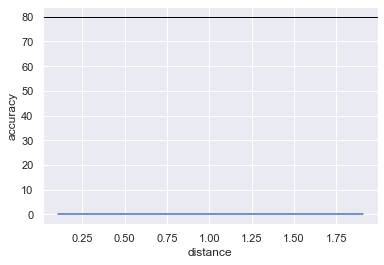

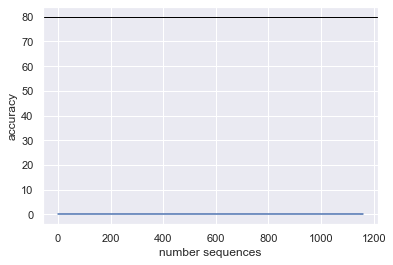

In [44]:
import matplotlib
cutoffs = np.linspace(distances.min(),distances.max(),100)
results = np.array([predictions,val_data[1], distances.squeeze()]).T
accuracies = []
number_sequences = []
lower_accuracy_found = False
low_accuracy_mask = np.ones(len(results))
for cutoff in cutoffs:
    indices = results[:, 2] <= cutoff
    below_cutoff = results[results[:, 2] <= cutoff]
    accuracy = np.equal(below_cutoff[:, 0], below_cutoff[:, 1]).sum() / len(below_cutoff)
    accuracy = 0
    accuracies.append(accuracy*100)
    if accuracy <= accuracy_threshold:
        lower_accuracy_found = True
    if accuracy >= accuracy_threshold and not lower_accuracy_found:
        high_accuracy_predictions = below_cutoff
        low_accuracy_mask = np.invert(indices)
    number_sequences.append(len(below_cutoff))

print(high_accuracy_predictions[:, 0])
print(high_accuracy_predictions[:, 1])
print(np.where(low_accuracy_mask)[0])
print(len(val_set))
val_kept = Subset(val_set,np.where(low_accuracy_mask)[0])
print(len(val_kept))
df = pd.DataFrame(np.array([cutoffs,accuracies, number_sequences]).T, columns=["distance", "accuracy", 'number sequences'])
distance_plot = sns.lineplot(data=df, x="distance", y="accuracy")
plt.axhline(y=80,linewidth=1, color='black')
plt.show()
sequences_plot = sns.lineplot(data=df, x="number sequences", y="accuracy")
plt.axhline(y=80,linewidth=1, color='black')


